In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

import xgboost as xgb

from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('./Datas/dataset_house.csv', index_col=0)
data

,type_of_property,subtype_of_property,locality,province,région,price,number_of_facades,house_area,house_area_cat,number_of_rooms,...,terrace,terrace_area,open_fire,swimming_pool,state_of_the_building,construction_year,construction_year_cat,price_per_m²,commune,rank_commune
0,house,house,1050,Bruxelles-Capitale,Région Bruxelles-capitale,340000,2.0,203.0,]180-240 m²],6,...,1,NaN,0,0,to be done up,1901.0,1900-1919,1674.88,IXELLES,578.0
1,house,villa,1880,Brabant flamand,Région flamande,525000,4.0,250.0,]240m²- ],6,...,1,40.0,0,0,as new,1992.0,1980-1999,2100.00,KAPELLE-OP-DEN-BOS,437.0
2,house,exceptional property,4900,Liège,Région wallonne,550000,4.0,475.0,]240m²- ],11,...,1,NaN,0,0,good,1853.0,older than 1900,1157.89,SPA,411.0
3,house,villa,7912,Hainaut,Région wallonne,550000,4.0,325.0,]240m²- ],4,...,1,NaN,0,0,good,1918.0,1900-1919,1692.31,FRASNES-LEZ-ANVAING,147.0
4,house,house,6032,Hainaut,Région wallonne,550000,3.0,400.0,]240m²- ],5,...,1,80.0,0,0,as new,1977.0,1960-1979,1375.00,CHARLEROI,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22217,house,house,2310,Anvers,Région flamande,468000,4.0,180.0,]120-180 m²],3,...,0,NaN,0,0,NaN,NaN,NaN,2600.00,RIJKEVORSEL,315.0
22218,house,house,1800,Brabant flamand,Région flamande,454993,3.0,169.0,]120-180 m²],3,...,0,NaN,0,0,NaN,NaN,NaN,2692.27,VILVOORDE,450.0
22219,house,villa,3530,Limbourg,Région flamande,475000,4.0,222.0,]180-240 m²],3,...,0,NaN,0,0,NaN,NaN,NaN,2139.64,HOUTHALEN-HELCHTEREN,241.0
22220,house,mansion,6700,Luxembourg,Région wallonne,475000,2.0,240.0,]180-240 m²],9,...,0,NaN,0,0,NaN,NaN,NaN,1979.17,ARLON,445.0


In [3]:
data.columns

Index(['type_of_property', 'subtype_of_property', 'locality', 'province',
       'région', 'price', 'number_of_facades', 'house_area', 'house_area_cat',
       'number_of_rooms', 'number_of_rooms_cat', 'surface_of_the_land',
       'surface_of_the_land_cat', 'fully_equipped_kitchen', 'garden',
       'garden_area', 'terrace', 'terrace_area', 'open_fire', 'swimming_pool',
       'state_of_the_building', 'construction_year', 'construction_year_cat',
       'price_per_m²', 'commune', 'rank_commune'],
      dtype='object')

In [4]:
'''Drop the unwanted columns'''
# as we split the houses and apartments we can drop the 'type_of_property column'
data.drop(['type_of_property'], axis=1, inplace=True)

# as some subtype have a very low amount of entries , we get rid of this category
data.drop(['subtype_of_property'], axis=1, inplace=True)

# we also drop 3 categories made for data analysis 
data.drop(['number_of_rooms_cat'], axis=1, inplace=True)
data.drop(['house_area_cat'], axis=1, inplace=True)
data.drop(['construction_year_cat'], axis=1, inplace=True)
data.drop(['locality'], axis=1, inplace=True)
data.drop(['price_per_m²'], axis=1, inplace=True)
data

,province,région,price,number_of_facades,house_area,number_of_rooms,surface_of_the_land,surface_of_the_land_cat,fully_equipped_kitchen,garden,garden_area,terrace,terrace_area,open_fire,swimming_pool,state_of_the_building,construction_year,commune,rank_commune
0,Bruxelles-Capitale,Région Bruxelles-capitale,340000,2.0,203.0,6,95.0,[0-5 ares],1,0,NaN,1,NaN,0,0,to be done up,1901.0,IXELLES,578.0
1,Brabant flamand,Région flamande,525000,4.0,250.0,6,826.0,]5-10 ares],1,1,430.0,1,40.0,0,0,as new,1992.0,KAPELLE-OP-DEN-BOS,437.0
2,Liège,Région wallonne,550000,4.0,475.0,11,1543.0,]10-50 ares],1,1,1400.0,1,NaN,0,0,good,1853.0,SPA,411.0
3,Hainaut,Région wallonne,550000,4.0,325.0,4,3570.0,]10-50 ares],1,1,2333.0,1,NaN,0,0,good,1918.0,FRASNES-LEZ-ANVAING,147.0
4,Hainaut,Région wallonne,550000,3.0,400.0,5,616.0,]5-10 ares],1,1,500.0,1,80.0,0,0,as new,1977.0,CHARLEROI,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22217,Anvers,Région flamande,468000,4.0,180.0,3,0.0,[0-5 ares],1,0,NaN,0,NaN,0,0,NaN,NaN,RIJKEVORSEL,315.0
22218,Brabant flamand,Région flamande,454993,3.0,169.0,3,389.0,[0-5 ares],0,0,NaN,0,NaN,0,0,NaN,NaN,VILVOORDE,450.0
22219,Limbourg,Région flamande,475000,4.0,222.0,3,1124.0,]10-50 ares],0,0,NaN,0,NaN,0,0,NaN,NaN,HOUTHALEN-HELCHTEREN,241.0
22220,Luxembourg,Région wallonne,475000,2.0,240.0,9,200.0,[0-5 ares],0,0,NaN,0,NaN,0,0,NaN,NaN,ARLON,445.0


In [5]:
to_drop = ['province', 'région', 'surface_of_the_land_cat', 'commune']
data_copy = data.copy()
for i in to_drop:
    data_copy.drop([i], axis=1, inplace=True)

data = data_copy
data

,price,number_of_facades,house_area,number_of_rooms,surface_of_the_land,fully_equipped_kitchen,garden,garden_area,terrace,terrace_area,open_fire,swimming_pool,state_of_the_building,construction_year,rank_commune
0,340000,2.0,203.0,6,95.0,1,0,NaN,1,NaN,0,0,to be done up,1901.0,578.0
1,525000,4.0,250.0,6,826.0,1,1,430.0,1,40.0,0,0,as new,1992.0,437.0
2,550000,4.0,475.0,11,1543.0,1,1,1400.0,1,NaN,0,0,good,1853.0,411.0
3,550000,4.0,325.0,4,3570.0,1,1,2333.0,1,NaN,0,0,good,1918.0,147.0
4,550000,3.0,400.0,5,616.0,1,1,500.0,1,80.0,0,0,as new,1977.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22217,468000,4.0,180.0,3,0.0,1,0,NaN,0,NaN,0,0,NaN,NaN,315.0
22218,454993,3.0,169.0,3,389.0,0,0,NaN,0,NaN,0,0,NaN,NaN,450.0
22219,475000,4.0,222.0,3,1124.0,0,0,NaN,0,NaN,0,0,NaN,NaN,241.0
22220,475000,2.0,240.0,9,200.0,0,0,NaN,0,NaN,0,0,NaN,NaN,445.0


In [6]:
'''We will labelize categorical feature "state_of_the_building" '''
# create the dict that will be use to replace values in the category
labels = data['state_of_the_building'].astype('category').cat.categories.tolist()
replace_map= {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}
print(replace_map)

{'as new': 1, 'good': 2, 'just renovated': 3, 'to be done up': 4, 'to renovate': 5, 'to restore': 6}


In [8]:
# save the dict to use it in the API 
import csv

dict_to_save = replace_map
w = csv.writer(open("./Datas/state_of_the_building_index.csv", "w"))
for key, val in dict_to_save.items():
    w.writerow([key, val])

In [9]:
# then we use replace method with the created dict
data.replace(replace_map, inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22222 entries, 0 to 22221
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   22222 non-null  int64  
 1   number_of_facades       19374 non-null  float64
 2   house_area              22222 non-null  float64
 3   number_of_rooms         22222 non-null  int64  
 4   surface_of_the_land     22087 non-null  float64
 5   fully_equipped_kitchen  22222 non-null  int64  
 6   garden                  22222 non-null  int64  
 7   garden_area             6430 non-null   float64
 8   terrace                 22222 non-null  int64  
 9   terrace_area            6236 non-null   float64
 10  open_fire               22222 non-null  int64  
 11  swimming_pool           22222 non-null  int64  
 12  state_of_the_building   16941 non-null  float64
 13  construction_year       12173 non-null  float64
 14  rank_commune            22222 non-null

## Set up the model

In [11]:
shape = data.shape
print(f"m = {shape[0]}, n = {shape[1] - 1}")

m = 22222, n = 14


In [12]:
# move the target column to end
col_to_put_end = ['price']
data = data[[c for c in data if c not in col_to_put_end] 
        + [c for c in col_to_put_end if c in data]]
data

,number_of_facades,house_area,number_of_rooms,surface_of_the_land,fully_equipped_kitchen,garden,garden_area,terrace,terrace_area,open_fire,swimming_pool,state_of_the_building,construction_year,rank_commune,price
0,2.0,203.0,6,95.0,1,0,NaN,1,NaN,0,0,4.0,1901.0,578.0,340000
1,4.0,250.0,6,826.0,1,1,430.0,1,40.0,0,0,1.0,1992.0,437.0,525000
2,4.0,475.0,11,1543.0,1,1,1400.0,1,NaN,0,0,2.0,1853.0,411.0,550000
3,4.0,325.0,4,3570.0,1,1,2333.0,1,NaN,0,0,2.0,1918.0,147.0,550000
4,3.0,400.0,5,616.0,1,1,500.0,1,80.0,0,0,1.0,1977.0,41.0,550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22217,4.0,180.0,3,0.0,1,0,NaN,0,NaN,0,0,NaN,NaN,315.0,468000
22218,3.0,169.0,3,389.0,0,0,NaN,0,NaN,0,0,NaN,NaN,450.0,454993
22219,4.0,222.0,3,1124.0,0,0,NaN,0,NaN,0,0,NaN,NaN,241.0,475000
22220,2.0,240.0,9,200.0,0,0,NaN,0,NaN,0,0,NaN,NaN,445.0,475000


In [14]:
data_test = data
'''data_test.drop(['fully_equipped_kitchen'], axis=1, inplace=True)
data_test.drop(['garden'], axis=1, inplace=True)
data_test.drop(['open_fire'], axis=1, inplace=True)
data_test.drop(['terrace'], axis=1, inplace=True)
data_test.drop(['swimming_pool'], axis=1, inplace=True)'''
data_test.columns

Index(['number_of_facades', 'house_area', 'number_of_rooms',
       'surface_of_the_land', 'garden_area', 'terrace_area',
       'state_of_the_building', 'construction_year', 'rank_commune', 'price'],
      dtype='object')

In [15]:
import math
from __future__ import division

from sklearn.linear_model import LinearRegression
from sklearn import tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.impute import SimpleImputer

#imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#data = imp.fit_transform(data)
# assign X and y
y = data_test.iloc[:,-1] #target
X = data_test.iloc[:, :-1] # features

In [16]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

In [17]:
xgb_reg = xgb.XGBRegressor(n_estimators=250, learning_rate=0.07, gamma=0, subsample=0.75,
                           colsample_bytree=0.9, max_depth=7)

In [23]:
xgb_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
predictions = xgb_reg.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.7069200934924188


In [25]:
xgb_reg.score(X_test,y_test)

0.7780177932521455

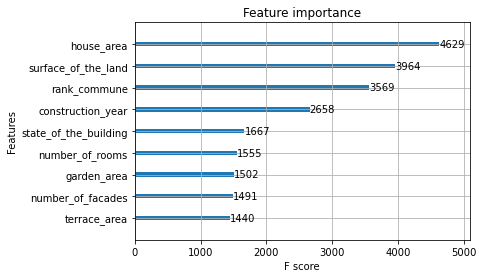

In [21]:
xgb.plot_importance(xgb_reg)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [22]:
import pickle

model_name = "House_model.pkl"

# save the model
pickle.dump(xgb_reg, open(model_name, "wb"))

# test 
loaded_model = pickle.load(open(model_name, "rb"))
print('model saved') if xgb_reg.score(X_test, y_test) == loaded_model.score(X_test, y_test) else print('error')

model saved


In [ ]:
''' 'number_of_facades', 'house_area', 'number_of_rooms',
       'surface_of_the_land', 'garden_area', 'terrace_area',
       'state_of_the_building', 'construction_year', 'rank_commune' '''

In [210]:
######################### TEST #################################

'''test_house_1= {'number_of_facades':[3], 'house_area':[128], 'number_of_rooms':[2],
       'surface_of_the_land':[845], 'garden_area':[0], 'terrace_area':[0],
       'state_of_the_building':[2],'construction_year':[1954], 'rank_commune':[129]}


test_house_2= {'number_of_facades':[2], 'house_area':[192], 'number_of_rooms':[4],
       'surface_of_the_land':[200],'garden_area':[0], 'terrace_area':[0],
       'state_of_the_building':[2],'construction_year':[1998], 'rank_commune':[450]}

test_house_3= {'number_of_facades':[2], 'house_area':[182], 'number_of_rooms':[3],
       'surface_of_the_land':[1421],'garden_area':[90], 'terrace_area':[30],
        'state_of_the_building':[3], 'construction_year':[1964], 'rank_commune':[572]}

test_immo = pd.DataFrame(data=test_house_1)
prediction = xgb_reg.predict(test_immo)
prediction'''

array([217179.98], dtype=float32)